In [27]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np
# from main import plot_statistics

### Load statistics

In [70]:
statspath = "./trained/PBTRainbow_TEST/pbt_stats.pickle"
(stats, def_params) = pickle.load(open(statspath, 'rb'))
if not type(stats) == pd.DataFrame:
    raise TypeError("Statistics are no Pandas DataFrame")
if def_params == None:
    raise Exception("Default parameters missing")

### agglomerate train episode records, calculate mean and std

In [71]:
#flatten out all train measurements because these are nested lists for each entry:
for measure in ['train_episode_lengths', 'train_episode_returns',
                'train_episode_environment_reward', 'train_episode_hint_reward',
                'train_episode_play_reward', 'train_episode_discard_reward']:
    stats[measure] = stats[measure].apply(lambda x: [item for sublist in x for item in sublist])
#stats now is assumed to be a correctly formatted DataFrame
#aggregate lists into mean and std for given axes
for measure in ['train_episode_lengths', 'train_episode_returns',
               'train_episode_environment_reward', 'train_episode_hint_reward',
               'train_episode_play_reward', 'train_episode_discard_reward',
               'eval_episode_lengths', 'eval_episode_returns',
               'eval_episode_environment_rewards', 'eval_episode_hint_rewards',
               'eval_episode_play_rewards', 'eval_episode_discard_rewards']:
    stats[f"mean_{measure}"] = stats[measure].apply(np.mean)
    stats[f"std_{measure}"] = stats[measure].apply(np.std)

train_episode_lengths
train_episode_returns
train_episode_environment_reward
train_episode_hint_reward
train_episode_play_reward
train_episode_discard_reward


### plot

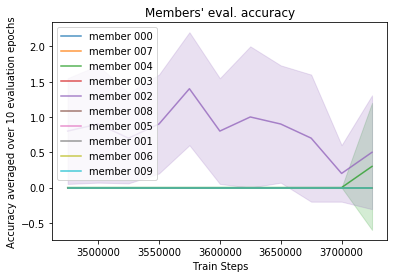

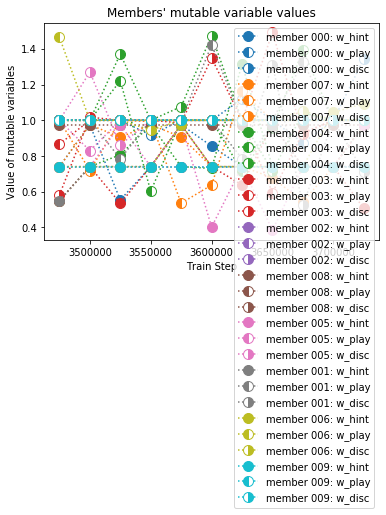

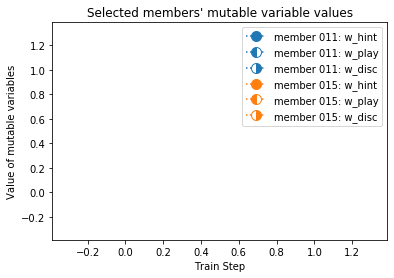

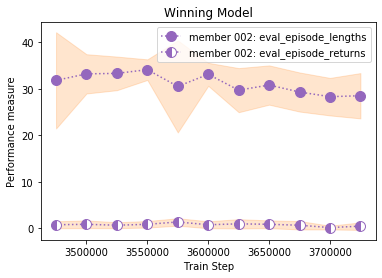

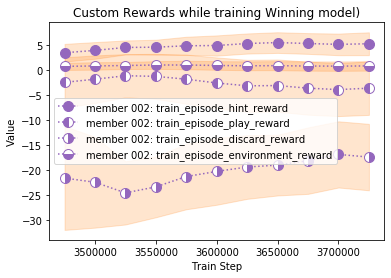

In [76]:
#get ids and corresponding colors globally to keep colors consistent across plots
ids = list(set(stats["id"]))
n_membs = len(ids)
# colors = cm.get_cmap("gist_rainbow", n_membs)
marker_style = dict(linestyle=':', marker='o',
                    markersize=10, markerfacecoloralt='white')

#evaluation accuracy of all models
fig, ax = plt.subplots()
ax.set_title("Members' eval. accuracy")
for i, id in enumerate(ids): #iterate over members
    id_df = stats[stats.id==id] #pick subset of data
    ax.plot(id_df.train_step, id_df.mean_eval_episode_returns, color=f'C{i}', label='member '+id, alpha=0.8)
    ax.fill_between(id_df.train_step,
                    id_df.mean_eval_episode_returns - id_df.std_eval_episode_returns,
                    id_df.mean_eval_episode_returns + id_df.std_eval_episode_returns,
                    color=f'C{i}', alpha=0.2)
ax.legend()
ax.set_ylabel(f'Accuracy averaged over {def_params["num_evaluation_games"]} evaluation epochs')
ax.set_xlabel("Train Steps")

#values of mutables over time
fig, ax = plt.subplots()
ax.set_title("Members' mutable variable values")
for i, id in enumerate(ids): #iterate over members
    id_df = stats[stats.id==id] #pick subset of data
    for mutable, fillstyle in zip(def_params["pbt_mutables"],Line2D.fillStyles):
        ax.plot(id_df.train_step, id_df[mutable], color=f'C{i}', label=f'member {id}: {mutable}',
                fillstyle = fillstyle, **marker_style)
ax.legend()
ax.set_ylabel("Value of mutable variables")
ax.set_xlabel("Train Step")

#handpicked models' mutables over time
fig, ax = plt.subplots()
ax.set_title("Selected members' mutable variable values")
good_ids = ['011','015']
for i, id in enumerate(good_ids): #iterate over members
    id_df = stats[stats.id==id] #pick subset of data
    for mutable, fillstyle in zip(def_params["pbt_mutables"],Line2D.fillStyles):
        ax.plot(id_df.train_step, id_df[mutable], color=f'C{i}', label=f'member {id}: {mutable}',
                fillstyle = fillstyle, **marker_style)
ax.legend()
ax.set_ylabel("Value of mutable variables")
ax.set_xlabel("Train Step")

#winning model average return, eval episode lengths and eval episode returns in close-up
winning_model_id = stats.iloc[stats.mean_eval_episode_returns.idxmax()].id
id_df = stats[stats.id == winning_model_id]  # pick subset of data
measures = ["eval_episode_lengths", "eval_episode_returns"]
fig, ax = plt.subplots()
ax.set_title("Winning Model")
for measure,fillstyle in zip(measures,Line2D.fillStyles):
    ax.plot(id_df.train_step, id_df[f"mean_{measure}"], color=f'C{ids.index(winning_model_id)}',
            label=f'member {winning_model_id}: {measure}', fillstyle = fillstyle, **marker_style)
    ax.fill_between(id_df.train_step,
                    id_df[f"mean_{measure}"] - id_df[f"std_{measure}"],
                    id_df[f"mean_{measure}"] + id_df[f"std_{measure}"],
                    color=f'C{i}', alpha=0.2)

ax.legend()
ax.set_ylabel("Performance measure")
ax.set_xlabel("Train Step")

#winning model average custom rewards over time 
fig, ax = plt.subplots()
ax.set_title("Custom Rewards while training Winning model)")
measures = ["train_episode_hint_reward", "train_episode_play_reward",
            "train_episode_discard_reward", "train_episode_environment_reward"]
for measure,fillstyle in zip(measures,Line2D.fillStyles):
    ax.plot(id_df.train_step, id_df[f"mean_{measure}"], color=f'C{ids.index(winning_model_id)}',
            label=f'member {winning_model_id}: {measure}', fillstyle = fillstyle, **marker_style)
    ax.fill_between(id_df.train_step,
                    id_df[f"mean_{measure}"] - id_df[f"std_{measure}"],
                    id_df[f"mean_{measure}"] + id_df[f"std_{measure}"],
                    color=f'C{i}', alpha=0.2)
ax.legend()

ax.set_ylabel("Value")
ax.set_xlabel("Train Step")

fig.show()

In [61]:
id_df['train_episode_hint_reward'].apply(lambda x: [item for sublist in x for item in sublist])

0      [0.41600000000000004, 0.36000000000000004, 1.4...
10     [1.552, 0.44800000000000006, 3.68, 0, 1.791999...
20     [1.048747559969868, 2.8114416618219704, 1.9755...
30     [2.31921764847459, 2.9333890525161412, 2.21722...
40     [0.310411539948798, 1.161826049522644, 1.89351...
50     [4.236276378560089, 6.665804834761755, 3.01809...
60     [5.563962351808324, 2.586934525195014, 5.96432...
70     [3.144699508801875, 4.455276126724745, 6.19016...
80     [4.5168698058960555, 6.422851989141588, 6.8095...
90     [6.31335211505926, 8.164584361263628, 3.818808...
100    [0.49274943337047894, 0.30796839585654934, 0.7...
Name: train_episode_hint_reward, dtype: object

In [75]:
stats.columns

Index(['train_episode_lengths', 'train_episode_returns',
       'train_episode_environment_reward', 'train_episode_hint_reward',
       'train_episode_play_reward', 'train_episode_discard_reward',
       'eval_episode_lengths', 'eval_episode_returns',
       'eval_episode_environment_rewards', 'eval_episode_hint_rewards',
       'eval_episode_play_rewards', 'eval_episode_discard_rewards', 'id',
       'parent_idx', 'pbt_step', 'train_step', 'w_hint', 'w_play', 'w_disc',
       'mean_train_episode_lengths', 'std_train_episode_lengths',
       'mean_train_episode_returns', 'std_train_episode_returns',
       'mean_train_episode_environment_reward',
       'std_train_episode_environment_reward',
       'mean_train_episode_hint_reward', 'std_train_episode_hint_reward',
       'mean_train_episode_play_reward', 'std_train_episode_play_reward',
       'mean_train_episode_discard_reward', 'std_train_episode_discard_reward',
       'mean_eval_episode_lengths', 'std_eval_episode_lengths',
      

In [67]:
stats.columns

Index(['train_episode_lengths', 'train_episode_returns',
       'train_episode_environment_reward', 'train_episode_hint_reward',
       'train_episode_play_reward', 'train_episode_discard_reward',
       'eval_episode_lengths', 'eval_episode_returns',
       'eval_episode_environment_rewards', 'eval_episode_hint_rewards',
       'eval_episode_play_rewards', 'eval_episode_discard_rewards', 'id',
       'parent_idx', 'pbt_step', 'train_step', 'w_hint', 'w_play', 'w_disc'],
      dtype='object')

id_df